In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test, ON_THRESHOLD
from sklearn.metrics import mean_absolute_error
import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../code/')
%matplotlib inline
import itertools
from pathlib import Path

In [22]:
tensor = np.load("../2015-5appliances.numpy.npy")
dr = tensor[:, 3]

In [23]:
# calculate gt
test_gt = {}
valid_gt = {}
for fold_num in range(5):
    test_gt[fold_num] = {}
    valid_gt[fold_num] = {}
    train, test = get_train_test(1, 5, fold_num)
    valid = train[int(0.8*len(train)):].copy()
    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]):
        test_gt[fold_num][appliance] = test[:, idx+1]
        valid_gt[fold_num][appliance] = valid[:, idx+1]

In [24]:
threshold = {}
for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
    sample_list = []
    for fold_num in range(5):
        sample_list = np.append(sample_list, [x for x in test_gt[fold_num][appliance].reshape(1, -1).tolist()[0] if x > ON_THRESHOLD[appliance]])
    mean = np.mean(sample_list)
    print(appliance, mean)
    threshold[appliance] = 0.1*mean

hvac 1108.31654375
fridge 88.0752343178
dr 1232.46729397
dw 352.193042043
mw 64.8640824305


In [26]:
def calculate_error(pred, gt, threshold):
    error = {}
    overall = {}
    num_homes = {}
    
    # calculte number of homes in each fold
    for fold_num in range(5):
        num_homes[fold_num] = gt[fold_num]['hvac'].reshape(-1, 1, 112,24).shape[0]
    homes = pd.Series(num_homes).sum()
    
    for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        error[appliance] = {}
        overall[appliance] = 0                                                                
        for fold_num in range(5):
            error[appliance][fold_num] = onoff_error(pred[fold_num][appliance].reshape(-1, 24), 
                                                     gt[fold_num][appliance].reshape(-1, 24), threshold[appliance])
            overall[appliance] += error[appliance][fold_num]*num_homes[fold_num]
        overall[appliance] /= homes
    
    
    return error, overall

In [27]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

# load valid prediction

In [8]:
dataset = 1
stf_param = np.load("../code/baseline/result/stf-new-param-{}.npy".format(dataset)).item()
cnn_tree_param = np.load("../code/baseline/result/cnn-tree-new-param-{}.npy".format(dataset)).item()
cnn_individual_param = np.load("../code/baseline/result/cnn-individual-new-param-{}.npy".format(dataset)).item()

In [16]:
# for stf
stf_pred = {}
for fold_num in range(5):
    stf_pred[fold_num] = {}
    num_latent = stf_param[fold_num]['num_latent']
    lr = float(stf_param[fold_num]['lr'])
    iters = stf_param[fold_num]['iters']
    filename = "../code/baseline/stf/{}/test/stf-test-pred-{}-{}-{}-{}-{}.npy".format(dataset, dataset, fold_num, num_latent, lr, iters)
    
    result = np.load(filename)
    for idx, appliance in enumerate(APPLIANCE_ORDER[1:-1]): 
        stf_pred[fold_num][appliance] = result[:, idx]

In [14]:
# get prediction for cnn individual
cnn_individual_pred = {}
for fold_num in range(5):
    cnn_individual_pred[fold_num] = {}
    for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        
        lr = cnn_individual_param[fold_num][appliance]['lr']
        iters = cnn_individual_param[fold_num][appliance]['iters']

        directory = "../code/baseline/cnn-tree/{}/{}/{}/200000/0.0/".format(dataset, fold_num,lr)
        filename = "test-pred-[\'{}\'].npy".format(appliance)

        full_path = directory + filename
        cnn_individual_pred[fold_num][appliance] = np.asarray(np.load(full_path).item()[iters]).reshape(-1, 1, 112, 24)

In [15]:
# get prediction for cnn tree
cnn_tree_pred = {}
for fold_num in range(5):
    cnn_tree_pred[fold_num] = {}
        
    lr = cnn_tree_param[fold_num]['lr']
    iters = cnn_tree_param[fold_num]['iters']
    order = cnn_tree_param[fold_num]['order']

    o = "\', \'".join(str(x) for x in order)
    directory = "../code/baseline/cnn-tree/{}/{}/{}/20000/0.0/".format(dataset, fold_num,lr)
    filename = "test-pred-[\'{}\'].npy".format(o)

    full_path = directory + filename
    cnn_pred = np.asarray(np.load(full_path).item()[iters])
    
    for idx, appliance in enumerate(order):
        cnn_tree_pred[fold_num][appliance] = cnn_pred[idx].reshape(-1, 1, 112,24)
    

In [58]:
appliance = 'dr'
fold_num = 1

In [59]:
onoff_error(stf_pred[fold_num][appliance].reshape(-1 ,24), test_gt[fold_num][appliance].reshape(-1 ,24), threshold[appliance])

428.16669003943485

In [60]:
onoff_error(cnn_individual_pred[fold_num][appliance].reshape(-1 ,24), test_gt[fold_num][appliance].reshape(-1 ,24), threshold[appliance])

619.15726270053256

In [61]:
onoff_error(cnn_tree_pred[fold_num][appliance].reshape(-1 ,24), test_gt[fold_num][appliance].reshape(-1 ,24), threshold[appliance])

697.10504302601657

In [67]:
cnn_individual_pred[fold_num][appliance][0][0]

(14, 1, 112, 24)

In [82]:
stf_abs_error = np.abs(stf_pred[fold_num][appliance].reshape(-1 ,24) - test_gt[fold_num][appliance].reshape(-1 ,24))
stf_error = [x for x in stf_abs_error.reshape(1, -1).tolist()[0] if x >= threshold[appliance]]

In [90]:
cnn_ind_abs_error = np.abs(cnn_individual_pred[fold_num][appliance].reshape(-1 ,24) - test_gt[fold_num][appliance].reshape(-1 ,24))
cnn_ind_error = [x for x in cnn_ind_abs_error.reshape(1, -1).tolist()[0] if x >= threshold[appliance]]

In [83]:
cnn_tree_abs_error = np.abs(cnn_tree_pred[fold_num][appliance].reshape(-1 ,24) - test_gt[fold_num][appliance].reshape(-1 ,24))
cnn_tree_error = [x for x in cnn_tree_abs_error.reshape(1, -1).tolist()[0] if x >= threshold[appliance]]

In [95]:
threshold

{'dr': 123.24672939681733,
 'dw': 35.219304204253916,
 'fridge': 8.8075234317837303,
 'hvac': 110.8316543749247,
 'mw': 6.4864082430525887}

In [91]:
print(len(stf_error), np.mean(stf_error))
print(len(cnn_ind_error), np.mean(cnn_ind_error))

7544 428.166690039
3143 619.157262701


(array([  6.11700000e+03,   4.11000000e+02,   3.33000000e+02,
          2.63000000e+02,   2.13000000e+02,   9.40000000e+01,
          5.70000000e+01,   3.40000000e+01,   1.90000000e+01,
          3.00000000e+00]),
 array([  123.25065252,   526.3721295 ,   929.49360648,  1332.61508346,
         1735.73656044,  2138.85803742,  2541.9795144 ,  2945.10099138,
         3348.22246836,  3751.34394534,  4154.46542232]),
 <a list of 10 Patch objects>)

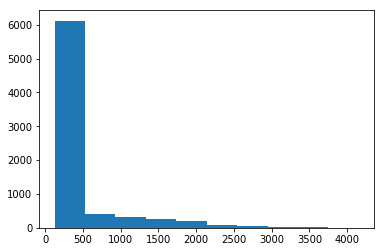

In [97]:
plt.hist(stf_error)

(array([  1.45100000e+03,   8.25000000e+02,   4.58000000e+02,
          2.29000000e+02,   1.07000000e+02,   4.30000000e+01,
          2.00000000e+01,   6.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([  123.40607452,   456.66597977,   789.92588501,  1123.18579025,
         1456.4456955 ,  1789.70560074,  2122.96550598,  2456.22541122,
         2789.48531647,  3122.74522171,  3456.00512695]),
 <a list of 10 Patch objects>)

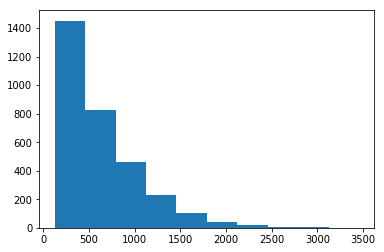

In [96]:
plt.hist(cnn_ind_error)

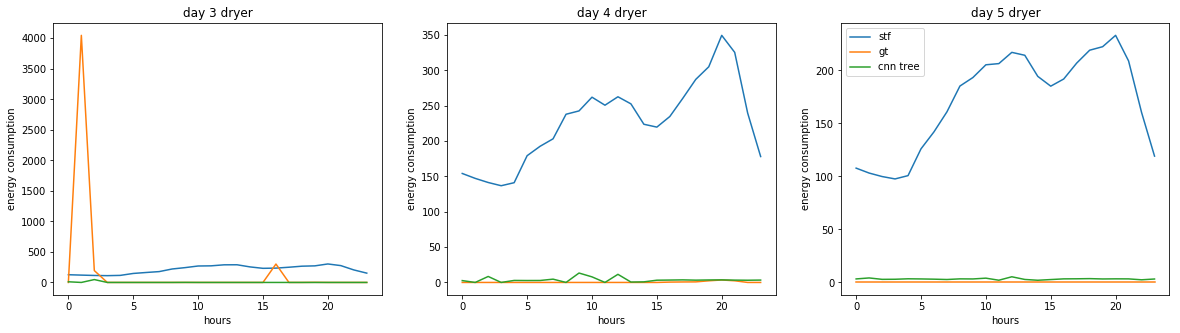

In [123]:
fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(20, 5))
ax = axes.flatten()

for i, k in enumerate([5]):

    for j, hid in enumerate([3, 4, 8]):
        pd.Series(stf_pred[fold_num][appliance][k][hid]).plot(ax=ax[i*3+j])
        pd.Series(test_gt[fold_num][appliance][k][hid]).plot(ax=ax[i*3+j])
#         pd.Series(cnn_individual_pred[fold_num][appliance][i][0][hid]).plot(ax=ax[i*3+j])
        pd.Series(cnn_tree_pred[fold_num][appliance][k][0][hid]).plot(ax=ax[i*3+j])
        ax[i*3+j].set_xlabel("hours")
        ax[i*3+j].set_ylabel("energy consumption")
ax[0].set_title("day 3 dryer")
ax[1].set_title("day 4 dryer")
ax[2].set_title("day 5 dryer")
ax[i*3+j].legend(['stf', 'gt', 'cnn tree'])